# Livneh and WRF California Average

In [1]:
# imports
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
import xarray as xr
# Spatial subsetting of netcdf files
import regionmask


# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

Livneh Averages

In [2]:
# reading in livneh
fn = '/cw3e/mead/projects/cwp103/scratch/ldehaan/Livneh/ptt_2017.nc'
liv = xr.open_dataset(fn)

In [3]:
# Download natural earth data which contains state boundaries to generate AOI
#et.data.get_data(
    #url="https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_1_states_provinces_lakes.zip")

states_path = "ne_50m_admin_1_states_provinces_lakes.shp"

states_gdf = gpd.read_file(states_path)
states_gdf.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,geometry
0,Admin-1 scale rank,2,AUS-2651,2651,AU-WA,None,AU,6,Western Australia,None,...,West-Australië,Australia Zachodnia,Austrália Ocidental,Западная Австралия,Western Australia,Batı Avustralya,Tây Úc,西澳大利亚州,1159315805,"MULTIPOLYGON (((113.13181 -25.95199, 113.14823..."
1,Admin-1 scale rank,2,AUS-2650,2650,AU-NT,None,AU,6,Northern Territory,None,...,Noordelijk Territorium,Terytorium Północne,Território do Norte,Северная территория,Northern Territory,Kuzey Toprakları,Lãnh thổ Bắc Úc,北領地,1159315809,"MULTIPOLYGON (((129.00196 -25.99901, 129.00196..."
2,Admin-1 scale rank,2,AUS-2655,2655,AU-SA,None,AU,3,South Australia,None,...,Zuid-Australië,Australia Południowa,Austrália Meridional,Южная Австралия,South Australia,Güney Avustralya,Nam Úc,南澳大利亚州,1159313267,"MULTIPOLYGON (((129.00196 -31.69266, 129.00196..."
3,Admin-1 scale rank,2,AUS-2657,2657,AU-QLD,None,AU,5,Queensland,None,...,Queensland,Queensland,Queensland,Квинсленд,Queensland,Queensland,Queensland,昆士蘭州,1159315807,"MULTIPOLYGON (((138.00196 -25.99901, 138.00174..."
4,Admin-1 scale rank,2,AUS-2660,2660,AU-TAS,None,AU,5,Tasmania,None,...,Tasmanië,Tasmania,Tasmânia,Тасмания,Tasmanien,Tasmanya,Tasmania,塔斯馬尼亞州,1159313261,"MULTIPOLYGON (((147.31246 -43.28038, 147.34238..."


In [4]:
# You will use the bounds to determine the slice values for this data
# Select any state in the CONUS that you wish here! California is the default
cali_aoi = states_gdf[states_gdf.name == "California"]
# Get the total spatial extent for California
cali_aoi.total_bounds

array([-124.37165376,   32.53336527, -114.12501824,   42.00076797])

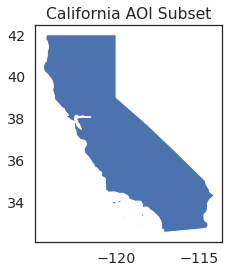

In [5]:
# This is the AOI of interest. You only want to calculate summary values for
# pixels within this AOI rather the entire rectangular spatial extent.
f, ax = plt.subplots()
cali_aoi.plot(ax=ax)
ax.set(title="California AOI Subset")

plt.show()

In [6]:
# Create a 3d mask - this contains the true / false values identifying pixels
# inside vs outside of the mask region
cali_mask = regionmask.mask_3D_geopandas(cali_aoi,
                                         liv.lon,
                                         liv.lat)
cali_mask

<xarray.DataArray 'region' (region: 1, lat: 444, lon: 922)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float64 25.16 25.22 25.28 25.34 ... 52.66 52.72 52.78 52.84
  * lon      (lon) float64 -124.6 -124.5 -124.5 -124.4 ... -67.16 -67.09 -67.03
  * region   (region) int64 53

In [7]:
# Apply the mask for California to the data
liv_ca = liv.where(cali_mask)
liv_ca

<xarray.Dataset>
Dimensions:  (Time: 365, lat: 444, lon: 922, region: 1)
Coordinates:
  * Time     (Time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
  * lat      (lat) float64 25.16 25.22 25.28 25.34 ... 52.66 52.72 52.78 52.84
  * lon      (lon) float64 -124.6 -124.5 -124.5 -124.4 ... -67.16 -67.09 -67.03
  * region   (region) int64 53
Data variables:
    Tmax     (Time, lat, lon, region) float32 nan nan nan nan ... nan nan nan
    Tmin     (Time, lat, lon, region) float32 nan nan nan nan ... nan nan nan
    PRCP     (Time, lat, lon, region) float32 nan nan nan nan ... nan nan nan
Attributes:
    missing_value:  -1e+36

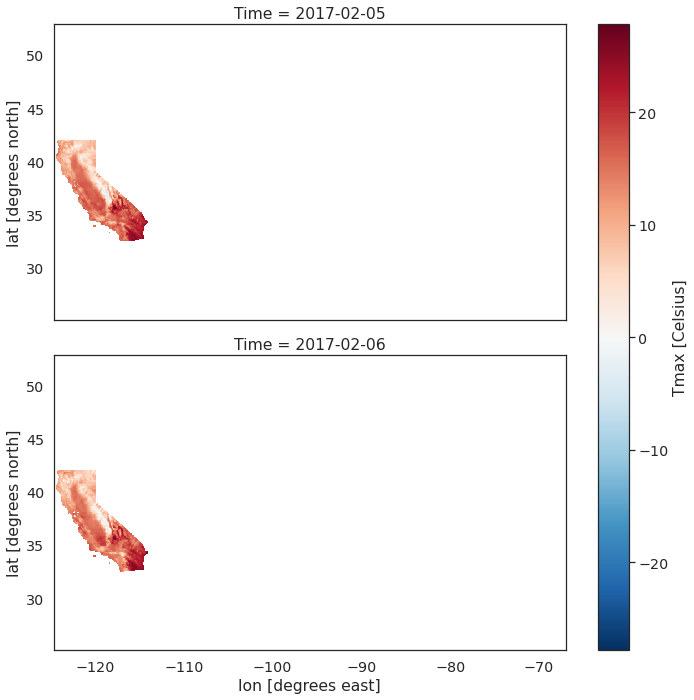

In [8]:
# plotting masking for reference
liv_ca['Tmax'][35:37].plot(col='Time',col_wrap=1,figsize=(10, 10))
plt.show()

In [9]:
# averaging
def avg(start, nxt, end):
    sum_arr = liv_ca['Tmax'][start].data
    for i in np.arange(nxt, end):
        sum_arr += liv_ca['Tmax'][i].data
    avg = sum_arr / 10
    return avg
avg_liv = avg(36, 37, 46)

In [10]:
# janky way to find average using wrf coords, subtracting livneh avg/pt by random 
# wrf to create nans then adding livneh avg/pt back so we can remove pts not in common
wrf_05 = xr.open_dataset('./wrf_05.nc')
wf = wrf_05['maxes'].data.flatten()
wf[wf == 0.0] = 'nan'
sub = np.subtract(avg_liv.flatten(), wf)
avg_liv = np.add(wf, sub)

# convert dif_arr to masked array to overlook NaNs
import numpy.ma as ma
m_out = ma.masked_invalid(avg_liv)

In [11]:
# numerical avg stat over entire region
print("livnhe avg: ", np.mean(m_out.flatten()), min(np.unique(m_out)), max(np.unique(m_out)))

livnhe avg:  15.01043687263611 -3.317330837249756 28.143198013305664


WRF Average

In [12]:
# reading in wrf tmaxes
wrf_06a = xr.open_dataset('./wrf_06.nc')
wrf_07a = xr.open_dataset('./wrf_07.nc')
wrf_08a = xr.open_dataset('./wrf_08.nc')
wrf_09a = xr.open_dataset('./wrf_09.nc')
wrf_10a = xr.open_dataset('./wrf_10.nc')
wrf_11a = xr.open_dataset('./wrf_11.nc')
wrf_12a = xr.open_dataset('./wrf_12.nc')
wrf_13a = xr.open_dataset('./wrf_13.nc')
wrf_14a = xr.open_dataset('./wrf_14.nc')
wrf_15a = xr.open_dataset('./wrf_15.nc')
wrf_lsta = [wrf_06a, wrf_07a, wrf_08a, wrf_09a, wrf_10a, wrf_11a, wrf_12a, wrf_13a, wrf_14a, wrf_15a]
print(np.mean(wrf_06a['maxes'].data.flatten()))

95.70200726165687


In [13]:
# reading in wrf shifted tmaxes
wrf_06a1 = xr.open_dataset('./wrf_06_prev-Copy1.nc')
wrf_07a1 = xr.open_dataset('./wrf_07_prev-Copy1.nc')
wrf_08a1 = xr.open_dataset('./wrf_08_prev-Copy1.nc')
wrf_09a1 = xr.open_dataset('./wrf_09_prev-Copy1.nc')
wrf_10a1 = xr.open_dataset('./wrf_10_prev-Copy1.nc')
wrf_11a1 = xr.open_dataset('./wrf_11_prev-Copy1.nc')
wrf_12a1 = xr.open_dataset('./wrf_12_prev-Copy1.nc')
wrf_13a1 = xr.open_dataset('./wrf_13_prev-Copy1.nc')
wrf_14a1 = xr.open_dataset('./wrf_14_prev-Copy1.nc')
wrf_15a1 = xr.open_dataset('./wrf_15_prev-Copy1.nc')
wrf_lsta1 = [wrf_06a1, wrf_07a1, wrf_08a1, wrf_09a1, wrf_10a1, wrf_11a1, wrf_12a1, wrf_13a1, wrf_14a1, wrf_15a1]
print(np.mean(wrf_06a1['maxes'].data.flatten()))

96.30123465947534


In [14]:
# Apply the mask for California to the data
def masking(lst):
    wrf_lst = []
    for i in wrf_lsta:
        temp = i.where(cali_mask)
        wrf_lst.append(temp)
    return wrf_lst
no_shift_lst = masking(wrf_lsta)
shift_lst = masking(wrf_lsta1)

In [15]:
# averaging
def averaging(lst):
    sum_arr1 = lst[0]['maxes'].data
    for i in lst[1:]:
         sum_arr1 += i['maxes'].data
    avg1 = sum_arr1 / 10
    return avg1
no_shft_avg = averaging(no_shift_lst)
shft_avg = averaging(shift_lst)

# change 0.0 to NaNs
no_shft_avg[no_shft_avg == 0.0] = 'nan'
shft_avg[shft_avg == 0.0] = 'nan'

# janky way to find average using livneh coords, subtracting wrf avg/pt by random 
# livneh to create nans then adding livneh avg/pt back so we can remove wrf pts not in common
fn = '/cw3e/mead/projects/cwp103/scratch/ldehaan/Livneh/ptt_2017.nc'
liv = xr.open_dataset(fn)
livran = liv['Tmax'][35].data.flatten()
sub = np.subtract(no_shft_avg.flatten(), livran)
sub1 = np.subtract(shft_avg.flatten(), livran)
no_shft_avg = np.add(sub, livran)
shft_avg = np.add(sub1, livran)

In [18]:
# convert dif_arr to masked array to overlook NaNs
import numpy.ma as ma
no_out = ma.masked_invalid(no_shft_avg)
shft_out = ma.masked_invalid(shft_avg)

# convert from K to C
no_out = no_out - 273.15
shft_out = shft_out- 273.15

(409368, 409368)

In [17]:
# numerical average over entire region
print("no shift: ", np.mean(no_out.flatten()))
print("shift: ", np.mean(shft_out.flatten()))

no shift:  13.859714061855387
shift:  13.859714061855387


fin.